In [1]:
# For this notebook, we've picked an instance of maxcut. Other problems are more interesting,
# but this is the one always used in the literature.

# The goal here is to setup a Maxcut QAOA instance using qiskit, and execute it on the qiskit simulator
# using the ColdQuanta API. To validate our results, we will look for the canonical ``qaoa landscape" and 
# see that it loses contrast when the noise is increased.

In [2]:
from coldquanta.qiskit_tools.coldquanta_sim_backend import ColdQuantaSimBackend
# Set up a 2x2 grid topology.
rows = cols = 2
neutral_atom = ColdQuantaSimBackend(rows=rows, cols=cols)
neutral_atom_config = neutral_atom.configuration()
coupling_map = neutral_atom_config.coupling_map

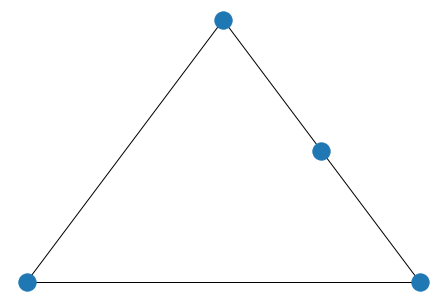

In [6]:
from networkx import Graph, draw_planar
g = Graph(coupling_map)
draw_planar(g)

In [133]:
# We will currently only accept QAOA instances on graphs isomorphic to our own -
# i.e. we are not implementing a compiler. Provide them as a dictionary.

# Uniform weights.
weights = {tuple(k): 1 for k in coupling_map}

In [149]:
# It looks like Qiskit hasn't implemented any kind of exponentiation - 
# in particular, they write to use "an Ising-type gate":
# https://qiskit.org/textbook/ch-applications/qaoa.html#2.1-(weighted)-$MAXCUT$
# Rigetti has implemented an exponentiate-like feature -
# http://docs.rigetti.com/en/stable/apidocs/autogen/pyquil.paulis.exponentiate.html#pyquil.paulis.exponentiate

# For this example, everything is diagonal and we are free to just compute the QAOA circuit from the weights.
# Taking from the qiskit tutorial:
from qiskit import QuantumCircuit
def qaoa_circuit(gamma, beta):
    QAOA = QuantumCircuit(rows*cols) #qubits, classical bits
    # apply the layer of Hadamard gates to all qubits, and then fence all qubits.
    QAOA.h(range(rows*cols))
    QAOA.barrier()

    # apply the Ising type gates with angle gamma along the edges in E
    for edge, weight in weights.items():
        k = edge[0]
        l = edge[1]
        # The following is a gate decomposition for a exp(-i*\gamma*ZZ). **UNVERIFIED**.
        # Controlled-U1 gate - i.e. Controlled phase.
        QAOA.cu1(-2*gamma*weight, k, l)
        QAOA.u1(gamma, k)
        QAOA.u1(gamma, l)

    # then apply the single qubit X - rotations with angle beta to all qubits
    QAOA.barrier()
    #\exp^{-i\beta\sigma_x} = RX(2*\beta), so the factor of two keeps us consistent with https://arxiv.org/pdf/1411.4028 
    QAOA.rx(-2*beta, range(rows*cols))
    QAOA.measure_all()
    return QAOA


In [72]:
qaoa_circuit(0,0).draw()

┌───┐ ░      ┌───────┐    ┌───────┐              ┌───────┐    ┌───────┐»
   q_0: ┤ H ├─░──■───┤ U1(0) ├─■──┤ U1(0) ├──────────■───┤ U1(0) ├─■──┤ U1(0) ├»
        ├───┤ ░  │0  ├───────┤ │  └───────┘┌───────┐ │0  ├───────┤ │  └───────┘»
   q_1: ┤ H ├─░──■───┤ U1(0) ├─┼─────■─────┤ U1(0) ├─■───┤ U1(0) ├─┼─────■─────»
        ├───┤ ░      ├───────┤ │0    │     ├───────┤     ├───────┤ │0    │     »
   q_2: ┤ H ├─░───■──┤ U1(0) ├─■─────┼─────┤ U1(0) ├──■──┤ U1(0) ├─■─────┼─────»
        ├───┤ ░   │0 ├───────┤       │0    ├───────┤  │0 ├───────┤       │0    »
   q_3: ┤ H ├─░───■──┤ U1(0) ├───────■─────┤ U1(0) ├──■──┤ U1(0) ├───────■─────»
        └───┘ ░      └───────┘             └───────┘     └───────┘             »
meas_0: ═══════════════════════════════════════════════════════════════════════»
                                                                               »
meas_1: ═══════════════════════════════════════════════════════════════════════»
                                                                               »
meas_2: ═══════════════════════════════════════════════════════════════════════»
                                                                               »
meas_3: ═══════════════════════════════════════════════════════════════════════»
                                                                               »
«                  ░ ┌───────┐ ░ ┌─┐         
«   q_0: ──────────░─┤ RX(0) ├─░─┤M├─────────
«        ┌───────┐ ░ ├───────┤ ░ └╥┘┌─┐      
«   q_1: ┤ U1(0) ├─░─┤ RX(0) ├─░──╫─┤M├──────
«        ├───────┤ ░ ├───────┤ ░  ║ └╥┘┌─┐   
«   q_2: ┤ U1(0) ├─░─┤ RX(0) ├─░──╫──╫─┤M├───
«        ├───────┤ ░ ├───────┤ ░  ║  ║ └╥┘┌─┐
«   q_3: ┤ U1(0) ├─░─┤ RX(0) ├─░──╫──╫──╫─┤M├
«        └───────┘ ░ └───────┘ ░  ║  ║  ║ └╥┘
«meas_0: ═════════════════════════╩══╬══╬══╬═
«                                    ║  ║  ║ 
«meas_1: ════════════════════════════╩══╬══╬═
«                                       ║  ║ 
«meas_2: ═══════════════════════════════╩══╬═
«                                          ║ 
«meas_3: ══════════════════════════════════╩═
«

In [157]:
import numpy as np
discretization = 100
gammas = np.linspace(0, np.pi/2, discretization)
betas = np.linspace(0, np.pi/2, discretization)

In [158]:
from qiskit import Aer, execute
simulator = Aer.get_backend('qasm_simulator')
num_shots = 1024
experiments = []
for gamma in gammas:
    for beta in betas:
        experiments.append(qaoa_circuit(gamma, beta))
job = execute(experiments, backend=simulator, shots=num_shots)    
all_counts = job.result().get_counts()

In [159]:
def estimate_cost(counts, weights):
    cost = 0
    for assignment, count in counts.items():
        for edge, weight in weights.items():
            if assignment[edge[0]] != assignment[edge[1]]:
                # We've cut this edge.
                cost += weight*count
    # The coupling map currently includes both directions for all couplings. Since we've assumed an undirected
    # graph, we just divide by two.
    cost /= 2
    return cost/sum(counts.values()) 

landscape = np.zeros((discretization, discretization))
for i, gamma in enumerate(gammas):
    for j, beta in enumerate(betas):
        landscape[i][j] = estimate_cost(all_counts[i*len(betas) + j], weights)

3.068359375
0.921875


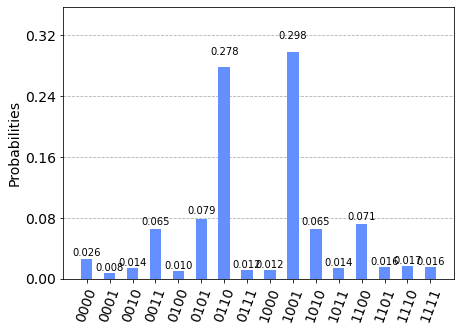

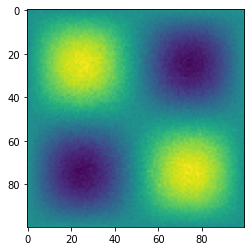

In [176]:
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram

plt.imshow(landscape)
print(np.max(landscape))
print(np.min(landscape))
plot_histogram(all_counts[np.argmax(landscape)])

IndexError: index 2627 is out of bounds for axis 0 with size 100